# Parametric shape optimization with differentiable FEM simulation

## Introduction

In this notebook, we explore the optimization of a parametric structure made of a linear elastic material.

We denote the design space as a function $g$ that maps the design variables to a signed distance field. Then, we can then define the density field $\rho(\mathbf{x})$ as a function of a signed distance field (SDF) value $g(\mathbf{x})$. For adaptive meshing, we define a sizing field $h(\mathbf{x})$ as a function of the SDF value as well.
We introduce an adpative differentiable mesher $m$ that takes the sizing field and returns a hex mesh. Finally we denote the differentiable finite element method (FEM) solver as $f$, which takes the density field and the hex mesh as input and returns the structure's compliance.  Therefore, the optimization problem can be formulated as follows:

$$
\begin{equation}
\min_{\theta} f(m(g(\theta)), \rho(g(\theta))).
\end{equation}
$$

Here, $\theta$ is the vector of design variables.

1. Manually defining gradient of solver 
2. Improving the parametrization of the design space, simplify
3. Definining jacobian manually

## Setup

In [26]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

In [27]:
# import tesseract_core

# tesseract_core.build_tesseract("design_tess", "latest")
# tesseract_core.build_tesseract("fem_tess", "latest")
# tesseract_core.build_tesseract("meshing_tess", "latest")
# print("Tesseract built successfully.")

## Design Space Tesseract

In [32]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from tesseract_core import Tesseract
from tesseract_core.runtime.experimental import TesseractReference
from utils import hex_to_pyvista, plot_grid, plot_grid_slice, plot_mesh, stop_grads_int

from tesseract_jax import apply_tesseract

In [33]:
# design_tess = Tesseract.from_image("design-tube-sdf")
# design_tess.serve()
IP = "172.26.3.35"
port = 443
url = f"http://{IP}:{port}"

design_tess = Tesseract.from_tesseract_api("sdf_fd_tess/tesseract_api.py")
stl_tess = Tesseract.from_url(url)
# stt_tess = Tesseract.from_tesseract_api("bars_3d_tess/tesseract_api.py")

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [34]:
Nx, Ny, Nz = 250, 200, 10
Lx, Ly, Lz = 50, 40, 2

grid_fin_params = {
    "angular_positions": jnp.array(
        [
            [0, 3.14],
            [0.39, 3.53],
            [0.79, 3.93],
            [1.18, 4.32],
            [1.57, 4.71],
            [1.96, 5.11],
            [2.36, 5.50],
            [2.75, 5.89],
        ]
    ),
    "plane_height": 400,
    "plane_thickness": 100,
    "cuttin_plane_1": 200,
    "cuttin_plane_2": 200,
}

# lets create a flat parameter array from the grid fin params
init_diffable_params = jnp.concatenate(
    [
        jnp.array(
            [grid_fin_params["cuttin_plane_1"], grid_fin_params["cuttin_plane_2"]]
        ),
        grid_fin_params["angular_positions"].flatten(),
    ]
).astype(jnp.float32)

normalization_factors = 1 / jnp.array([1000, 1000] + [3.14 * 2] * 16, dtype=jnp.float32)
normalization_bias = jnp.zeros_like(normalization_factors)


def normalize(params, norms, bias):
    return params * norms + bias


def denormalize(params, norms, bias):
    return (params - bias) / norms


init_diffable_params = normalize(
    init_diffable_params, normalization_factors, normalization_bias
)

non_diffable_paramas = jnp.array(
    [
        grid_fin_params["plane_height"],
        grid_fin_params["plane_thickness"],
    ],
    dtype=jnp.float32,
)

design_inputs = {
    "non_differentiable_parameters": non_diffable_paramas,
    "normalization_factors": normalization_factors,
    "normalization_bias": normalization_bias,
    "static_parameters": [],
    "string_parameters": [
        "F:\\ANSYS Inc\\v242\\scdm\\SpaceClaim.exe",
        "geometry_generation.scscript",
    ],
    "mesh_tesseract": TesseractReference(stl_tess),
    # the z coordinate of the object is not centered, hence we need to offset the SDF grid origin
    "grid_center": [0.0, 0.0, Lz / 2],
    "grid_size": [Lx, Ly, Lz],
    "grid_elements": [Nx, Ny, Nz],
    "scale_mesh": 0.01,
    "max_points": 1000,
    "max_faces": 2000,
    "precompute_jacobian": True,
    "normalize_jacobian": False,
    "sdf_backend": "pyvista",
    "epsilon": 0.001,
}

print(init_diffable_params)

[0.2        0.2        0.         0.49999997 0.0621019  0.56210184
 0.12579617 0.62579614 0.18789807 0.68789804 0.24999999 0.74999994
 0.3121019  0.81369424 0.37579614 0.8757961  0.43789804 0.937898  ]


In [35]:
design_out = apply_tesseract(
    design_tess,
    {
        "differentiable_parameters": init_diffable_params,
        **design_inputs,
    },
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

Starting Jacobian precomputation thread...
Number of vertices: 224
Number of faces: 516


In [36]:
print(jnp.min(mesh["points"], axis=0))
print(jnp.max(mesh["points"], axis=0))

[-24.5 -20.    0. ]
[20. 20.  2.]


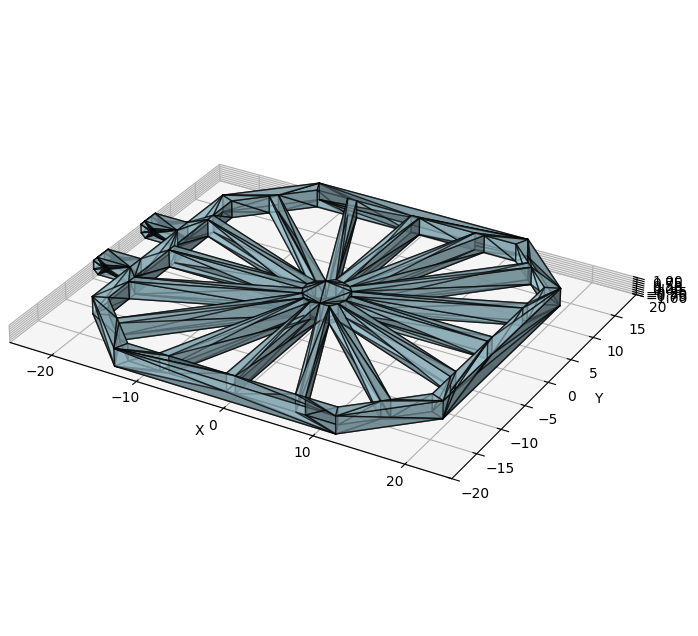

In [37]:
plot_mesh(mesh, [Lx, Ly, Lz])

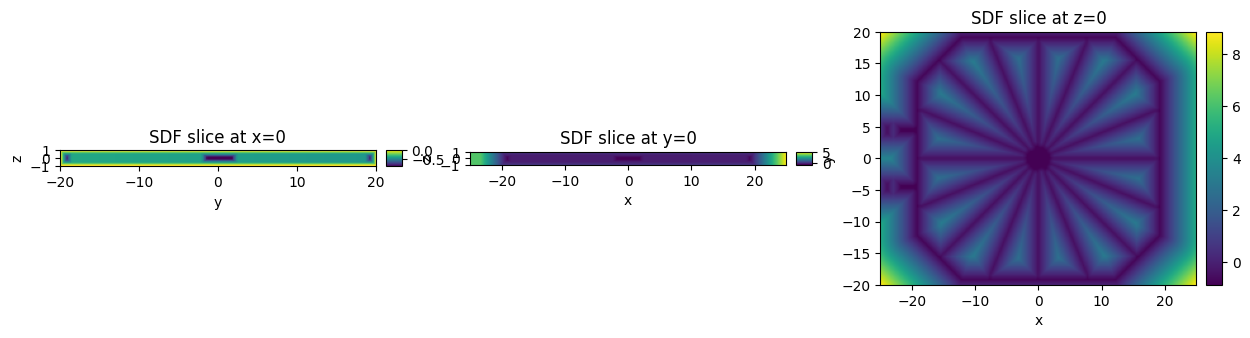

In [38]:
plot_grid(sdf, Lx, Ly, Lz, Nx, Ny, Nz, "SDF")

In [24]:
result = design_tess.jacobian(
    inputs={
        "differentiable_parameters": init_diffable_params,
        **design_inputs,
    },
    jac_inputs=["differentiable_parameters"],
    jac_outputs=["sdf"],
)

Using precomputed Jacobian...
Waiting for Jacobian precomputation to finish...


Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 10) and type: float32


(18, 250, 200, 10)


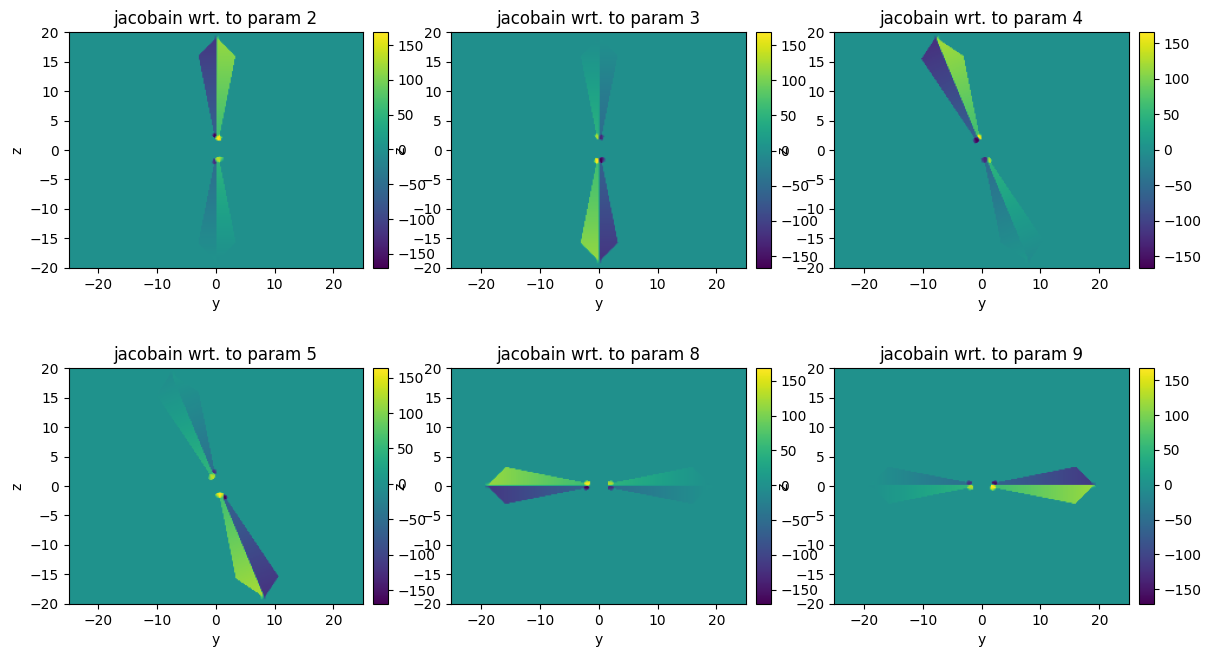

In [47]:
print(result["sdf"]["differentiable_parameters"].shape)
fig, axs = plt.subplots(2, 3, figsize=(14, 8))

plot_grid_slice(
    result["sdf"]["differentiable_parameters"][2][:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 0],
    title="jacobain wrt. to param 2",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    result["sdf"]["differentiable_parameters"][3][:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 1],
    title="jacobain wrt. to param 3",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    result["sdf"]["differentiable_parameters"][4][:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 2],
    title="jacobain wrt. to param 4",
    xlabel="y",
    ylabel="z",
)


plot_grid_slice(
    result["sdf"]["differentiable_parameters"][5][:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 0],
    title="jacobain wrt. to param 5",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    result["sdf"]["differentiable_parameters"][12][:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 1],
    title="jacobain wrt. to param 8",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    result["sdf"]["differentiable_parameters"][11][:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 2],
    title="jacobain wrt. to param 9",
    xlabel="y",
    ylabel="z",
)

[0.2        0.2        0.2        0.49999997 0.0621019  0.56210184
 0.12579617 0.62579614 0.18789807 0.68789804 0.24999999 0.74999994
 0.3121019  0.81369424 0.37579614 0.8757961  0.43789804 0.937898  ]


Starting Jacobian precomputation thread...
Number of vertices: 252
Number of faces: 584


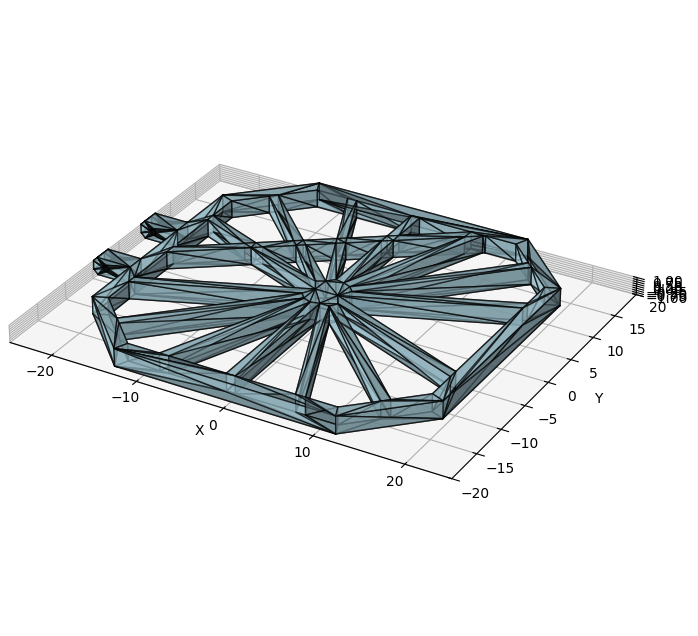

In [45]:
init_diffable_params_ = init_diffable_params.at[2].set(0.2)
print(init_diffable_params_)

design_out_ = apply_tesseract(
    design_tess,
    {
        "differentiable_parameters": init_diffable_params_,
        **design_inputs,
    },
)
sdf_ = design_out_["sdf"]
surface_mesh_ = design_out_["mesh"]

num_vertices = surface_mesh_["n_points"]
num_faces = surface_mesh_["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points_ = surface_mesh_["points"][:num_vertices]
faces_ = surface_mesh_["faces"][:num_faces]

mesh_ = {
    "points": points_,
    "faces": faces_,
}
plot_mesh(mesh_, [Lx, Ly, Lz])

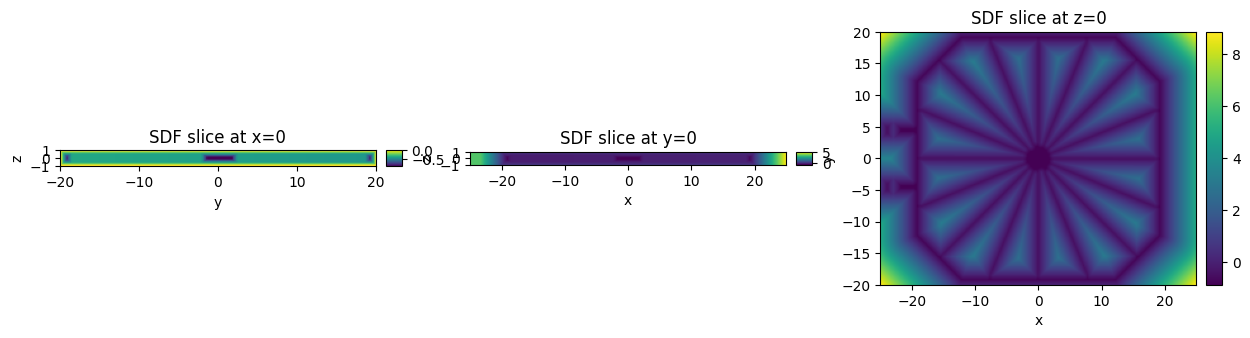

In [42]:
plot_grid(sdf_, Lx, Ly, Lz, Nx, Ny, Nz, "SDF")

rho min: 0.0006263562245294452, rho max: 0.9241418242454529


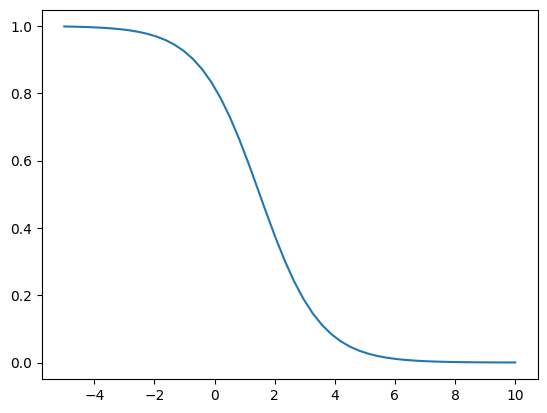

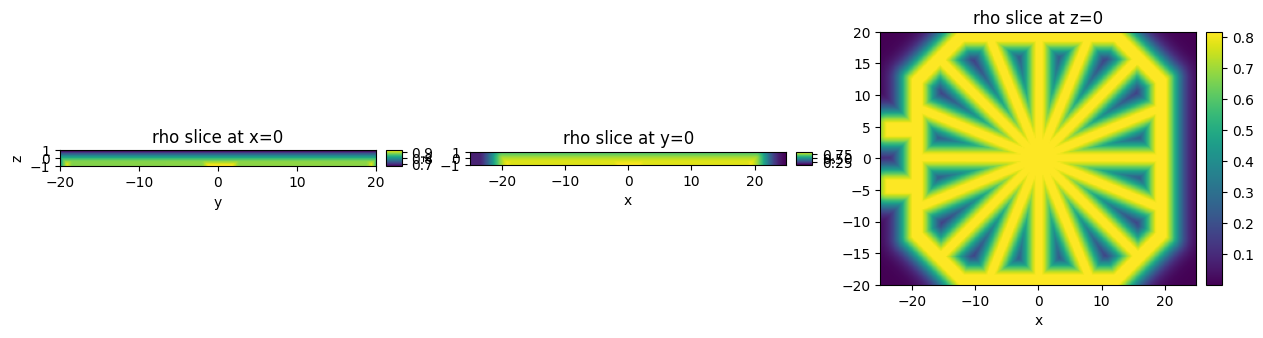

In [14]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho_scale = 1.0
rho_offset = 1.5

# plot the functions
sdfs = jnp.linspace(-5, 10)
rhos = sdf_to_rho(sdfs, scale=rho_scale, offset=rho_offset)

plt.plot(sdfs, rhos)


rho = sdf_to_rho(sdf, scale=rho_scale, offset=rho_offset)

plot_grid(rho, Lx, Ly, Lz, Nx, Ny, Nz, "rho")
print(f"rho min: {jnp.min(rho)}, rho max: {jnp.max(rho)}")

Sizing field min: 1.5625, max: 1.5625


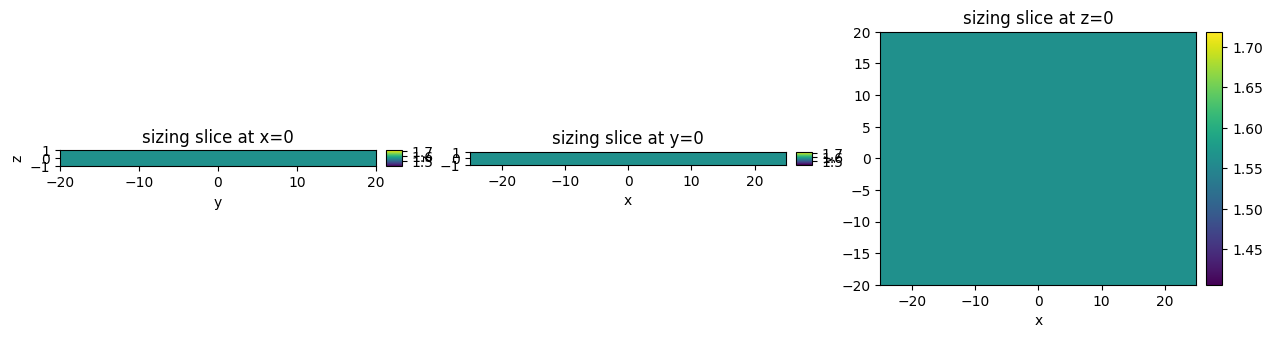

In [15]:
def sizing_field(
    sdf: jnp.ndarray, min_size: float = 0.1, max_size: float = 1.0, scale: float = 2.0
) -> jnp.ndarray:
    """Generate a sizing field from the signed distance function.

    The field is low (size = min_size) near the structure (sdf=0) and high (size = max_size) far from it.

    Args:
        sdf: Signed distance function values.
        min_size: Minimum element size near the structure.
        max_size: Maximum element size far from the structure.
        scale: Controls the transition steepness.

    Returns:
        Sizing field values.
    """

    def gauss(x: jnp.ndarray, mu: float, sigma: float) -> jnp.ndarray:
        return jnp.exp(-0.5 * ((x - mu) / sigma) ** 2)

    normalized_sdf = 1 - gauss(sdf, 0.0, 1.0 / scale)
    return min_size + (max_size - min_size) * normalized_sdf


sizing_min = Lx / 32
sizing_max = Lx / 32
sizing_scale = 0.2

sizing = sizing_field(sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale)
plot_grid(sizing, Lx, Ly, Lz, Nx, Ny, Nz, "sizing")
print(f"Sizing field min: {sizing.min()}, max: {sizing.max()}")

In [16]:
mesher = Tesseract.from_tesseract_api("meshing_tess/tesseract_api.py")

mesher_out = apply_tesseract(
    mesher,
    {
        "domain_size": [Lx, Ly, Lz],
        "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
        # "sizing_field": jnp.ones_like(sdf) * sizing_min,
        "field_values": rho,
        "max_subdivision_levels": 3,
        "max_points": 30000,
        "max_cells": 30000,
    },
)
print(
    f"Mesh points: {mesher_out['mesh']['n_points']}, Mesh faces: {mesher_out['mesh']['n_faces']}"
)
pts = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]

adaptive_mesh = mesher_out["mesh"]

No more subdivisions needed at level 1.
Done building mesh
Mesh points: 9261, Mesh faces: 5952


In [17]:
# convert arrays to numpy
pts_np = np.array(adaptive_mesh["points"])
cells_np = np.array(adaptive_mesh["faces"])

hex_mesh = hex_to_pyvista(pts_np, cells_np, {"rho": mesher_out["mesh_cell_values"]})

print(hex_mesh)

hex_mesh.save("grid_mesh.vtk")

UnstructuredGrid (0x782008262560)
  N Cells:    30000
  N Points:   30000
  X Bounds:   -2.500e+01, 2.500e+01
  Y Bounds:   -2.000e+01, 2.000e+01
  Z Bounds:   -1.000e+00, 1.000e+00
  N Arrays:   1


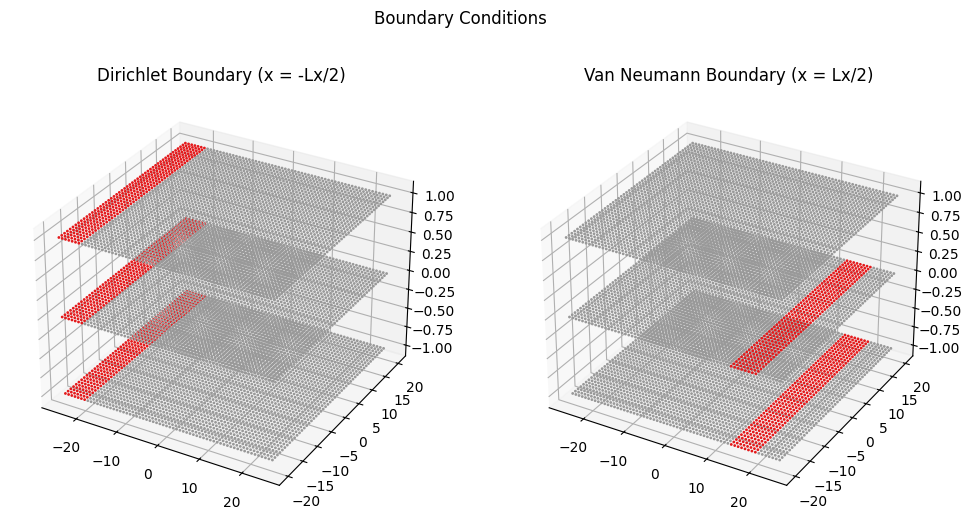

In [18]:
# Lets setup the boundary conditions
def get_boundary_masks(mesh: dict, Lx: float, Lz: float):
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Lz: Size of the domain in z-direction.

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        van_neumann_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = pts[:, 0] <= -Lx / 2 + Lx / 10
    van_neumann_mask = jnp.logical_and(
        jnp.isclose(pts[:, 0], (Lx / 2) - Lx / 6, atol=Lx / 16),
        jnp.isclose(pts[:, 2], -Lz / 2, atol=Lz / 2),
    )

    return dirichlet_mask, van_neumann_mask


dirichlet_mask, van_neumann_mask = get_boundary_masks(adaptive_mesh, Lx, Lz)

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
# set the colormap to Set1
plt.suptitle("Boundary Conditions")
# remove the axis ticks
colors = jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2)

pts = adaptive_mesh["points"][: adaptive_mesh["n_points"]]

axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=1,
    alpha=1.0,
    cmap="Set1",
)
axs[0].set_title("Dirichlet Boundary (x = -Lx/2)")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(van_neumann_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=1,
    alpha=1.0,
    cmap="Set1",
)
axs[1].set_title("Van Neumann Boundary (x = Lx/2)")

# convert to int arrays for tesseract input
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
van_neumann_mask = van_neumann_mask.astype(jnp.int32)

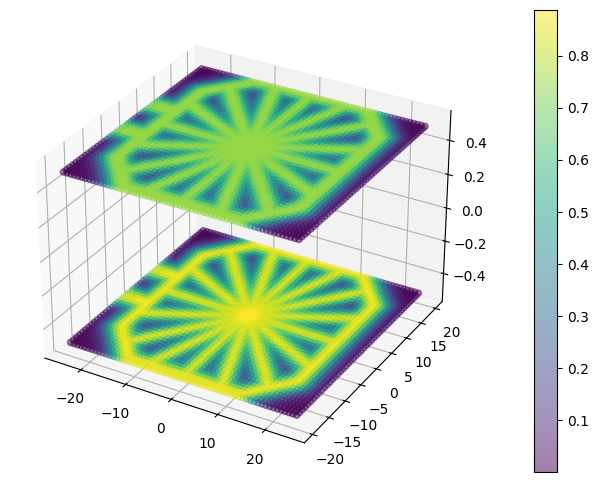

In [19]:
# lets make a scatter plot of the mesh cell values as colors
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={"projection": "3d"})
pts_coords = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)
rho_mesh = mesher_out["mesh_cell_values"][: mesher_out["mesh"]["n_faces"]]
scat = ax.scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=rho_mesh,
    s=20,
    # alpha=rho+0.3,
    alpha=0.5,
    cmap="viridis",
)
# colorbar
cbar = plt.colorbar(scat, ax=ax, pad=0.1)

In [20]:
fem_tess = Tesseract.from_tesseract_api("fem_tess/tesseract_api.py")

       __       ___      ___   ___                _______  _______ .___  ___. 
      |  |     /   \     \  \ /  /               |   ____||   ____||   \/   | 
      |  |    /  ^  \     \  V  /      ______    |  |__   |  |__   |  \  /  | 
.--.  |  |   /  /_\  \     >   <      |______|   |   __|  |   __|  |  |\/|  | 
|  `--'  |  /  _____  \   /  .  \                |  |     |  |____ |  |  |  | 
 \______/  /__/     \__\ /__/ \__\               |__|     |_______||__|  |__| 
                                                                              



[11-24 16:21:49][INFO] jax_fem: pyamgx not installed. AMGX solver disabled.


In [14]:
compliance = apply_tesseract(
    fem_tess,
    {
        "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
        "hex_mesh": adaptive_mesh,
        "dirichlet_mask": dirichlet_mask,
        "dirichlet_values": jnp.array([0.0]),
        "van_neumann_mask": van_neumann_mask,
        "van_neumann_values": jnp.array([[0.0, 0.0, 0.01]]),
    },
)["compliance"]
print(f"Compliance: {compliance:.4f}")

[11-24 14:40:39][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-24 14:40:39][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-24 14:40:39][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


[11-24 14:40:41][DEBUG] jax_fem: Done pre-computations, took 1.6715083122253418 [s]
[11-24 14:40:41][INFO] jax_fem: Solving a problem with 5952 cells, 9261x3 = 27783 dofs.
[11-24 14:40:41][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-24 14:40:42][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-24 14:40:42][DEBUG] jax_fem: Start timing
[11-24 14:40:42][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-24 14:40:43][DEBUG] jax_fem: Function split_and_compute_cell took 0.4979 seconds
[11-24 14:40:44][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-24 14:40:44][DEBUG] jax_fem: Before, l_2 res = 0.681295818327343, relative l_2 res = 1.0
[11-24 14:40:44][DEBUG] jax_fem: Solving linear system...
[11-24 14:40:44][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-24 14:40:47][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 5.610664581827073e-10
[11-24 14:40:47][DEBUG] j

Compliance: 9.6515


In [21]:
from jax import custom_vjp

grad_storage = {}


def store_values(x, x_dot, hash_val: int):
    global grad_storage
    print("Storing values in hash", hash_val)
    grad_storage[int(hash_val)] = (x, x_dot)


@custom_vjp
def identity_and_store_grads(x, hash_val: int):
    return x


def identity_fwd(x, hash_val):
    return x, (x, hash_val)


def identity_bwd(residuals, g):
    x, hash_val = residuals
    jax.debug.callback(store_values, x, g, hash_val, ordered=False)
    return (g, None)


identity_and_store_grads.defvjp(identity_fwd, identity_bwd)

In [22]:
@jax.custom_gradient
def gradient_clipping(x):
    return x, lambda g: (jnp.clip(g, -1.0, 1.0))

In [23]:
max_points = 20000
max_cells = 20000


def loss(
    params: jnp.ndarray,
    iteration: int = 0,
) -> tuple[float, dict]:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Geometry parameter array.
        iteration: Current iteration number.

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    sdf = identity_and_store_grads(params, iteration + 0)
    design_out = apply_tesseract(
        design_tess,
        {
            "differentiable_parameters": params,
            **design_inputs,
        },
    )

    sdf = design_out["sdf"]

    sdf = gradient_clipping(sdf)

    sdf = identity_and_store_grads(sdf, iteration + 1000)

    # Convert SDF to material density distribution
    rho_grid = sdf_to_rho(sdf, scale=rho_scale, offset=rho_offset)

    rho_grid = identity_and_store_grads(rho_grid, iteration + 2000)

    sizing = sizing_field(
        sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale
    )

    sizing = jax.lax.stop_gradient(sizing)

    mesher_out = apply_tesseract(
        mesher,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,
            # "sizing_field": jnp.ones_like(sdf) * sizing_min,
            "field_values": rho_grid,
            "max_subdivision_levels": 3,
            "max_points": max_points,
            "max_cells": max_cells,
        },
    )

    rho_cell = jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1)
    print(rho_cell)
    rho_cell = identity_and_store_grads(rho_cell, iteration + 3000)

    mesh = stop_grads_int(mesher_out["mesh"])

    dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, 0.01]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    c = apply_tesseract(
        fem_tess,
        {
            "rho": rho_cell,
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": van_neumann_values,
        },
    )["compliance"]

    # lets store all intermediate results in a dictionary to return
    # for visualization purposes
    surface_mesh = {
        "points": design_out["mesh"]["points"][: design_out["mesh"]["n_points"]],
        "faces": design_out["mesh"]["faces"][: design_out["mesh"]["n_faces"]],
    }

    hex_mesh = {
        "points": mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]],
        "faces": mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]],
        "rho": mesher_out["mesh_cell_values"][: mesher_out["mesh"]["n_faces"]],
    }

    return c, {
        "sdf": sdf,
        "rho_grid": rho_grid,
        "rho_cell": rho_cell,
        "sizing": sizing,
        "hex_mesh": hex_mesh,
        "surface_mesh": surface_mesh,
    }

In [24]:
grad_fn = jax.value_and_grad(loss, has_aux=True)

In [25]:
(loss_value, aux), grads = grad_fn(init_diffable_params, iteration=0)
print(f"loss {loss_value}, grads {grads}")

Starting Jacobian precomputation thread...


/anaconda/envs/fem/lib/python3.13/site-packages/numpy/_core/getlimits.py:559: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/anaconda/envs/fem/lib/python3.13/site-packages/numpy/_core/getlimits.py:91: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


No more subdivisions needed at level 1.
Done building mesh


[11-24 16:23:03][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-24 16:23:03][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-24 16:23:03][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


LinearizeTracer<float32[20000,1]>


[11-24 16:23:04][DEBUG] jax_fem: Done pre-computations, took 1.5572409629821777 [s]
[11-24 16:23:04][INFO] jax_fem: Solving a problem with 5952 cells, 9261x3 = 27783 dofs.
[11-24 16:23:04][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-24 16:23:06][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-24 16:23:06][DEBUG] jax_fem: Start timing
[11-24 16:23:06][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-24 16:23:07][DEBUG] jax_fem: Function split_and_compute_cell took 0.5047 seconds
[11-24 16:23:08][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-24 16:23:08][DEBUG] jax_fem: Before, l_2 res = 0.6812958464068648, relative l_2 res = 1.0
[11-24 16:23:08][DEBUG] jax_fem: Solving linear system...
[11-24 16:23:08][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-24 16:23:10][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 5.280231796036791e-10
[11-24 16:23:10][DEBUG] 

Storing values in hash 3000
No more subdivisions needed at level 1.
Done building mesh
Storing values in hash 2000
Storing values in hash 1000
Using precomputed Jacobian...
Waiting for Jacobian precomputation to finish...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 10) and type: float32
loss 9.651474952697754, grads [ 1.7640694e+01  6.2446251e+00 -1.9070408e+00  1.1826835e+00
 -8.3800421e+00  1.7570598e+00 -8.8134212e+00  1.9749367e-01
  8.1414375e+00  1.0723098e-02 -1.5925184e-01 -4.3444064e-01
  3.1142836e+00 -6.5114656e-03 -7.5268917e+00 -5.9939134e-01
  1.0271272e+01 -1.4731959e+00]


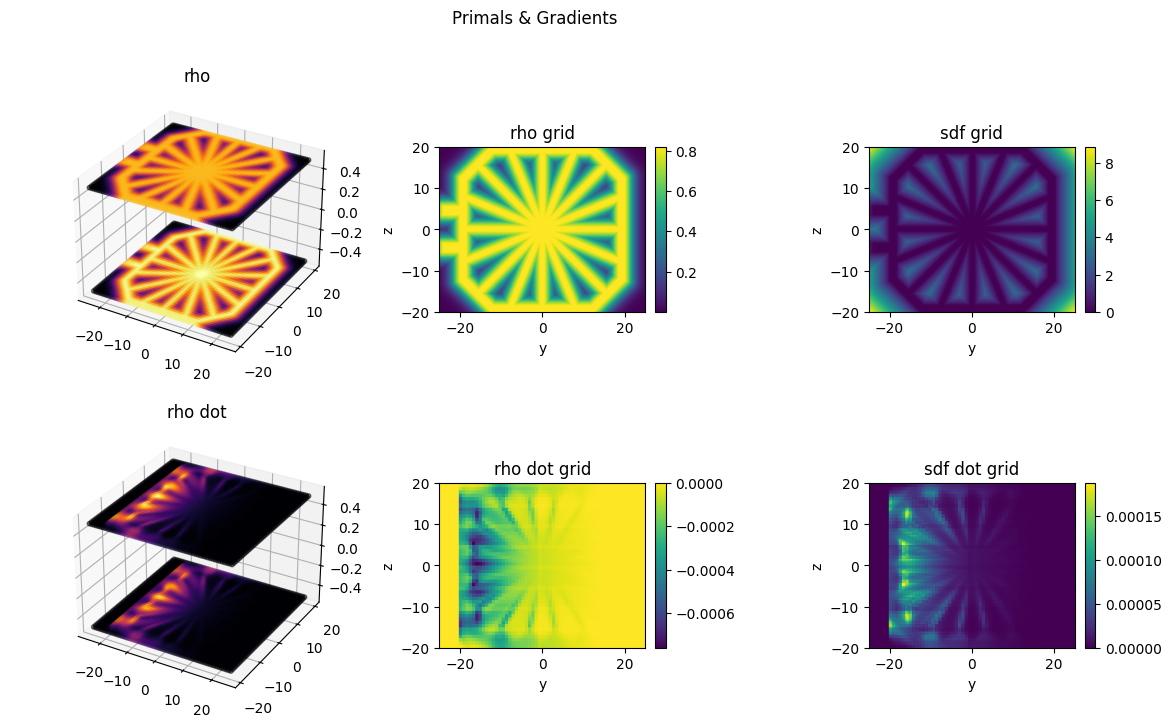

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
plt.suptitle("Primals & Gradients")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

ax = axs[0, 0]
for spine in ax.spines.values():
    spine.set_visible(False)

ax = axs[1, 0]
for spine in ax.spines.values():
    spine.set_visible(False)

# Set the first two subplots to 3D
axs[0, 0] = fig.add_subplot(2, 2, 1, projection="3d")
axs[1, 0] = fig.add_subplot(2, 2, 3, projection="3d")


mesh = aux["hex_mesh"]

pts_coords = mesh["points"]
hex_cells = mesh["faces"]
pts = jnp.mean(pts_coords[hex_cells], axis=1)

axs[0, 0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=mesh["rho"],
    s=10,
    alpha=0.5,
    cmap="inferno",
)
axs[0, 0].set_title("rho")

axs[1, 0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=-grad_storage[3000][1][: mesh["rho"].shape[0]],
    s=10,
    alpha=0.5,
    cmap="inferno",
)
axs[1, 0].set_title("rho dot")

plot_grid_slice(
    aux["rho_grid"][:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 1],
    title="rho grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    grad_storage[2000][1][:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 1],
    title="rho dot grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    aux["sdf"][:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 2],
    title="sdf grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    grad_storage[1000][1][:, :, Nz // 2],
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 2],
    title="sdf dot grid",
    xlabel="y",
    ylabel="z",
)

fig.subplots_adjust(wspace=0.9)
# fig.tight_layout(w_pad=3.0)

In [33]:
import optax

n_steps = 7
# strong learning rate decay
schedule = optax.exponential_decay(
    init_value=0.001, transition_steps=n_steps, decay_rate=0.9, staircase=False
)
optmizer = optax.sgd(learning_rate=schedule)

params = init_diffable_params.copy()
opt_state = optmizer.init(params)

# params = normalize(init_diffable_params.copy(), normalization_factors)
loss_hist = []
params_hist = []

grad_fn = jax.value_and_grad(loss, has_aux=True)

aux_hist = []

for i in range(n_steps):
    print(params)
    (loss_value, aux), grads = grad_fn(params, iteration=i)

    # grads = grads / jnp.max(grads)
    aux_hist.append(aux)

    print(jnp.max(grad_storage[3000 + i][1]))

    print(grads)

    updates, opt_state = optmizer.update(
        grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
    )
    params = optax.apply_updates(params, updates)

    params = params.at[0:2].set(init_diffable_params[0:2])

    loss_hist.append(loss_value)
    params_hist.append(params)

    print(f"Iteration {i + 1}, Loss: {loss_value:.4f}")

[0.2        0.2        0.         0.49999997 0.0621019  0.56210184
 0.12579617 0.62579614 0.18789807 0.68789804 0.24999999 0.74999994
 0.3121019  0.81369424 0.37579614 0.8757961  0.43789804 0.937898  ]


[11-24 16:43:49][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-24 16:43:49][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-24 16:43:49][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


No more subdivisions needed at level 1.
Done building mesh
LinearizeTracer<float32[20000,1]>


[11-24 16:43:50][DEBUG] jax_fem: Done pre-computations, took 0.9705374240875244 [s]
[11-24 16:43:50][INFO] jax_fem: Solving a problem with 5952 cells, 9261x3 = 27783 dofs.
[11-24 16:43:50][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-24 16:43:50][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-24 16:43:50][DEBUG] jax_fem: Start timing
[11-24 16:43:50][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-24 16:43:50][DEBUG] jax_fem: Function split_and_compute_cell took 0.3303 seconds
[11-24 16:43:50][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-24 16:43:51][DEBUG] jax_fem: Before, l_2 res = 0.6812958464068648, relative l_2 res = 1.0
[11-24 16:43:51][DEBUG] jax_fem: Solving linear system...
[11-24 16:43:51][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-24 16:43:53][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 5.280231796036791e-10
[11-24 16:43:53][DEBUG] 

Storing values in hash 3000
No more subdivisions needed at level 1.
Done building mesh
Storing values in hash 2000
Storing values in hash 1000
Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 10) and type: float32
0.0
[ 20.190022     4.6080027  -11.11636     10.698481    -3.5533018
  10.339144   -20.682621     5.8083425   49.2667     -10.171184
  -0.2987362  -49.82432     14.633974     3.8629258   -4.990867
   2.101028    -0.31647003  -1.8145859 ]
Iteration 1, Loss: 9.6515
[0.2        0.2        0.01111636 0.4893015  0.06565521 0.5517627
 0.14647879 0.6199878  0.13863137 0.6980692  0.2502987  0.79982424
 0.29746792 0.8098313  0.38078701 0.8736951  0.4382145  0.9397126 ]


[11-24 16:44:33][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-24 16:44:33][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-24 16:44:33][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


No more subdivisions needed at level 1.
Done building mesh
LinearizeTracer<float32[20000,1]>


[11-24 16:44:34][DEBUG] jax_fem: Done pre-computations, took 0.9837729930877686 [s]
[11-24 16:44:34][INFO] jax_fem: Solving a problem with 5952 cells, 9261x3 = 27783 dofs.
[11-24 16:44:34][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-24 16:44:34][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-24 16:44:34][DEBUG] jax_fem: Start timing
[11-24 16:44:34][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-24 16:44:34][DEBUG] jax_fem: Function split_and_compute_cell took 0.3331 seconds
[11-24 16:44:34][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-24 16:44:35][DEBUG] jax_fem: Before, l_2 res = 0.6812958464068648, relative l_2 res = 1.0
[11-24 16:44:35][DEBUG] jax_fem: Solving linear system...
[11-24 16:44:35][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-24 16:44:37][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 5.994334193679212e-10
[11-24 16:44:37][DEBUG] 

Storing values in hash 3001
No more subdivisions needed at level 1.
Done building mesh
Storing values in hash 2001
Storing values in hash 1001
Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 10) and type: float32
0.0
[ 20.278385    -1.6947595  -21.382526    17.641142    -8.665689
  25.77734    -15.589401     4.378519    47.290585    -9.760122
  -0.07810477 -52.67663     18.203758     8.386799   -14.389788
   2.3211098    0.23888555  -2.0801365 ]
Iteration 2, Loss: 10.4684
[0.2        0.2        0.03217946 0.4719239  0.07419144 0.52637047
 0.1618353  0.6156747  0.09204724 0.70768356 0.25037566 0.85171396
 0.2795361  0.8015698  0.39496183 0.87140864 0.4379792  0.9417617 ]


[11-24 16:45:17][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-24 16:45:17][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-24 16:45:17][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


No more subdivisions needed at level 1.
Done building mesh
LinearizeTracer<float32[20000,1]>


[11-24 16:45:18][DEBUG] jax_fem: Done pre-computations, took 0.975517988204956 [s]
[11-24 16:45:18][INFO] jax_fem: Solving a problem with 5952 cells, 9261x3 = 27783 dofs.
[11-24 16:45:18][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-24 16:45:18][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-24 16:45:18][DEBUG] jax_fem: Start timing
[11-24 16:45:18][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-24 16:45:19][DEBUG] jax_fem: Function split_and_compute_cell took 0.3372 seconds
[11-24 16:45:19][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-24 16:45:19][DEBUG] jax_fem: Before, l_2 res = 0.6812958464068648, relative l_2 res = 1.0
[11-24 16:45:19][DEBUG] jax_fem: Solving linear system...
[11-24 16:45:19][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-24 16:45:21][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 6.524032956862327e-10
[11-24 16:45:21][DEBUG] j

Storing values in hash 3002
Storing values in hash 2002
Storing values in hash 1002
No more subdivisions needed at level 1.
Done building mesh
Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 10) and type: float32
0.0
[ 20.390703    -2.7473924  -34.026825    29.084267   -15.01619
  45.72674    -14.565933     3.8526046   32.177002    -7.786083
   0.38029936 -65.809296    35.142303     6.2821436  -14.541109
   3.9813929    0.7112679   -3.001639  ]
Iteration 3, Loss: 11.6621
[0.2        0.2        0.06519724 0.4437021  0.08876234 0.48199973
 0.17596929 0.61193633 0.06082443 0.71523875 0.25000665 0.9155717
 0.24543592 0.795474   0.40907174 0.8675453  0.43728903 0.9446743 ]


[11-24 16:46:01][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-24 16:46:01][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-24 16:46:01][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


No more subdivisions needed at level 1.
Done building mesh
LinearizeTracer<float32[20000,1]>


[11-24 16:46:02][DEBUG] jax_fem: Done pre-computations, took 0.9872486591339111 [s]
[11-24 16:46:02][INFO] jax_fem: Solving a problem with 5952 cells, 9261x3 = 27783 dofs.
[11-24 16:46:02][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-24 16:46:03][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-24 16:46:03][DEBUG] jax_fem: Start timing
[11-24 16:46:03][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-24 16:46:03][DEBUG] jax_fem: Function split_and_compute_cell took 0.3277 seconds
[11-24 16:46:03][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-24 16:46:03][DEBUG] jax_fem: Before, l_2 res = 0.6812958464068648, relative l_2 res = 1.0
[11-24 16:46:03][DEBUG] jax_fem: Solving linear system...
[11-24 16:46:03][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-24 16:46:05][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 7.877314554939971e-10
[11-24 16:46:05][DEBUG] 

Storing values in hash 3003
No more subdivisions needed at level 1.
Done building mesh
Storing values in hash 2003
Storing values in hash 1003
Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 10) and type: float32
0.0
[ 24.195042   -1.53188   -24.800978   20.184391   -9.6152725  49.353535
 -25.790642    4.0516167  21.876669   -6.0248528   0.3033337 -55.30973
  45.18065     9.423143  -22.876244    5.4436417   0.9634949  -3.177001 ]
Iteration 4, Loss: 13.1560
[0.2        0.2        0.08890326 0.42440885 0.0979531  0.43482515
 0.20062126 0.6080636  0.03991362 0.72099763 0.2497167  0.96843946
 0.20225    0.7864669  0.430938   0.862342   0.43636808 0.94771105]


[11-24 16:46:46][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-24 16:46:46][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-24 16:46:46][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


No more subdivisions needed at level 1.
Done building mesh
LinearizeTracer<float32[20000,1]>


[11-24 16:46:47][DEBUG] jax_fem: Done pre-computations, took 0.9817941188812256 [s]
[11-24 16:46:47][INFO] jax_fem: Solving a problem with 5952 cells, 9261x3 = 27783 dofs.
[11-24 16:46:47][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-24 16:46:47][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-24 16:46:47][DEBUG] jax_fem: Start timing
[11-24 16:46:47][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-24 16:46:48][DEBUG] jax_fem: Function split_and_compute_cell took 0.3348 seconds
[11-24 16:46:48][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-24 16:46:48][DEBUG] jax_fem: Before, l_2 res = 0.6812958464068648, relative l_2 res = 1.0
[11-24 16:46:48][DEBUG] jax_fem: Solving linear system...
[11-24 16:46:48][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-24 16:46:50][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 7.287710065532011e-10
[11-24 16:46:50][DEBUG] 

Storing values in hash 3004
No more subdivisions needed at level 1.
Done building mesh
Storing values in hash 2004
Storing values in hash 1004
Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 10) and type: float32
0.0
[ 29.034805   -2.212632  -24.122437   20.049898  -10.41102    57.93802
 -36.897133    4.366978   35.989807   -7.900386    1.6744013 -25.66806
  19.141731   13.750906  -31.923094    6.6893587   0.7463508  -2.388042 ]
Iteration 5, Loss: 14.1165
[0.2        0.2        0.11161623 0.40553045 0.10775581 0.38027242
 0.23536251 0.60395175 0.00602668 0.7284364  0.24814013 0.9926078
 0.18422672 0.77351946 0.46099585 0.8560435  0.43566534 0.9499596 ]


[11-24 16:47:30][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-24 16:47:30][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-24 16:47:30][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


No more subdivisions needed at level 1.
Done building mesh
LinearizeTracer<float32[20000,1]>


[11-24 16:47:31][DEBUG] jax_fem: Done pre-computations, took 1.001598834991455 [s]
[11-24 16:47:31][INFO] jax_fem: Solving a problem with 5952 cells, 9261x3 = 27783 dofs.
[11-24 16:47:31][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-24 16:47:31][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-24 16:47:31][DEBUG] jax_fem: Start timing
[11-24 16:47:31][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-24 16:47:32][DEBUG] jax_fem: Function split_and_compute_cell took 0.3328 seconds
[11-24 16:47:32][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-24 16:47:32][DEBUG] jax_fem: Before, l_2 res = 0.6812958464068648, relative l_2 res = 1.0
[11-24 16:47:32][DEBUG] jax_fem: Solving linear system...
[11-24 16:47:32][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-24 16:47:34][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 6.162183998425022e-10
[11-24 16:47:34][DEBUG] j

Storing values in hash 3005
No more subdivisions needed at level 1.
Done building mesh
Storing values in hash 2005
Storing values in hash 1005
Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 10) and type: float32
0.0
[ 21.278645    -1.5598824  -22.571495    18.28568    -11.212448
  41.639942   -22.496578     3.5088098   35.28254     -8.613341
   2.5784175  -37.80462     20.658115     3.2406068   -4.335163
   4.8180075    0.58841646  -1.610873  ]
Iteration 6, Loss: 11.3322
[ 0.2         0.2         0.1325514   0.3885704   0.1181554   0.34165117
  0.2562282   0.60069734 -0.02669804  0.73642534  0.24574864  1.0276717
  0.16506623  0.7705138   0.46501672  0.8515748   0.43511957  0.9514537 ]


[11-24 16:48:14][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-24 16:48:14][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-24 16:48:14][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


No more subdivisions needed at level 1.
Done building mesh
LinearizeTracer<float32[20000,1]>


[11-24 16:48:15][DEBUG] jax_fem: Done pre-computations, took 0.9799025058746338 [s]
[11-24 16:48:15][INFO] jax_fem: Solving a problem with 5952 cells, 9261x3 = 27783 dofs.
[11-24 16:48:15][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-24 16:48:15][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-24 16:48:15][DEBUG] jax_fem: Start timing
[11-24 16:48:15][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-24 16:48:16][DEBUG] jax_fem: Function split_and_compute_cell took 0.3228 seconds
[11-24 16:48:16][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-24 16:48:16][DEBUG] jax_fem: Before, l_2 res = 0.6812958464068648, relative l_2 res = 1.0
[11-24 16:48:16][DEBUG] jax_fem: Solving linear system...
[11-24 16:48:16][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-24 16:48:18][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 6.068427486788127e-10
[11-24 16:48:18][DEBUG] 

Storing values in hash 3006
No more subdivisions needed at level 1.
Done building mesh
Storing values in hash 2006
Storing values in hash 1006
Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (18, 250, 200, 10) and type: float32
0.0
[ 21.044445    -1.5211514  -20.129272    17.46782    -11.490399
  37.72483    -20.33681      3.5988288   44.835068   -10.5615425
   2.5715206  -41.26588     20.582054    -0.58494806  -0.74284834
   4.6293445    0.6427653   -1.3199985 ]
Iteration 7, Loss: 11.3912


In [34]:
for i in range(n_steps):
    mesh = aux_hist[i]["hex_mesh"]
    rho_dot = grad_storage[i + 3000][1][: len(mesh["faces"])][:, 0]
    print(mesh["rho"].shape)
    print(rho_dot.shape)
    pv_mesh = hex_to_pyvista(
        mesh["points"], mesh["faces"], {"rho": mesh["rho"], "rho_dot": rho_dot}
    )
    pv_mesh.save(f"vtks/fem_shapeopt_mesh{i + 1}.vtk")

(5952,)
(5952,)
(5952,)
(5952,)
(5952,)
(5952,)
(5952,)
(5952,)
(5952,)
(5952,)
(5952,)
(5952,)
(5952,)
(5952,)


Text(0.5, 1.0, 'Compliance over Optimization')

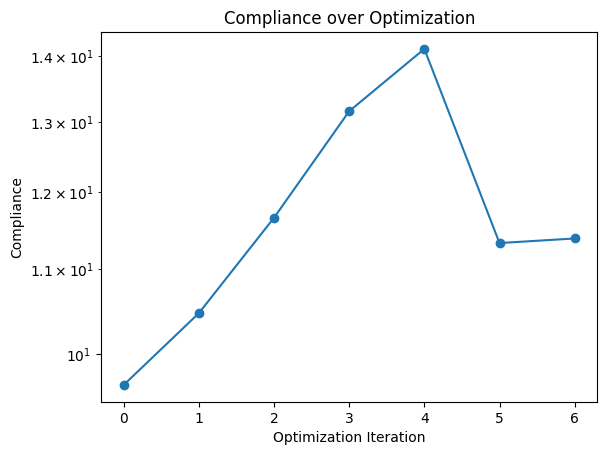

In [35]:
plt.plot(loss_hist, marker="o")
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization")

In [36]:
from matplotlib import animation

# repeat the last frame a few times to show the final result
params_hist = params_hist + [params] * 20

fig = plt.figure(figsize=(7, 4))

design_inputs["precompute_jacobian"] = False

ims = []
for aux in aux_hist:
    sdf = aux["sdf"]
    rho = aux["rho_grid"]

    im = plt.imshow((rho[:, :, :] > 0.8).sum(axis=2).T, origin="lower", cmap="viridis")
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=False, repeat_delay=2)
plt.close(fig)

ani.save("rho_optim_sum_2.gif", writer="pillow", fps=10)

In [37]:
# lets visualize the 3d meshes over the optimization
for i, aux in enumerate(aux_hist):
    plot_mesh(aux["surface_mesh"], save_path=f"tmp_img/mesh_optim_{i:03d}.png")

TypeError: plot_mesh() missing 1 required positional argument: 'bounds'